# Evaluating Quantum gradients with Parameter Shift Rule

## 1. Evaluating gradients of a quantum circuit

Evaluating gradients of a loss function $J(\vec{\theta})$ is a crucial task when dealing with 
machine learning problems, especially using Artificial Neural Networks (ANNs).
Gradient-based optimizers implement an iterative updating of the variational 
parameters of a model in order to minimize the target loss function:
$$ \vec{\theta}_{t+1} = \vec{\theta}_{t} - \eta \nabla_{\vec{\theta}} J(\vec{\theta}_t),  $$
with $\eta$ learning rate of the process and $t$ indicates the $t$-th iteration 
of the optimization.

<img src="figures/sgd.png" width="600" height="600" align="center"/>


## 2. Back-Propagation is a problem in QML

In che classical ML context, we typically calculates gradients using the Back-Propagation
algorithm, which needs access to the information during the propagation in order to
evaluate the gradients. This cannot be done when the model is a quantum circuit 
and the information is obtained as expected value of some observable. In fact,
information can be extracted by measuring the system, and measurements provoke
the collapse of the quantum state. Measuring in the middle of the executions means 
to loose all the stored information. 


<img src="figures/bp_qml.png" width="600" height="600" align="center"/>


**We need an alternative to the back-propagation**
if we want to execute a gradient-based optimization using a real quantum computer.

> **Finite differences is not a solution!**: information in QML is calculated as 
> expected value of observables. We will always have some shot-noise and, nowadays
> we only have NISQ devices (they are not able to reach arbitrary precision in 
> representing unitaries and they are not protected via quantum error correction).
> For this reason, the exact simulation is the only scenario in which a standard
> numerical method can work.

## 3. The parameter Shift Rule

An interesting way to calculate quantum gradients was presented [1] and then 
formalised in more details in [2]
and is called Parameter Shift Rule (PSR). Let's define $G(\theta)$ the expected 
value of our observable $\hat{O}$ over the final state $|q_f \rangle$ obtained by applying 
a parametric circuit $C(\theta)$ to an initial state: $|q_f \rangle  \equiv \mathcal{C}(\theta)|0\rangle$. We are 
considering for simplicity the direct dependence on a single parameter $\theta$.


<img src="figures/start.png" width="600" height="600" align="center"/>


### 3.1 The magic of the PSR

In a few words, if some conditions are satisfied:

- $\theta$ affects at most one gate of the form $U(\theta) = e^{-i\theta W}$, with $W$ hermitian generator of $U$;
- the hermitian generator of this gate has at most two eigenvalues $\pm r$,

we can evaluate the derivative of $G(\theta)$ as follows:

$$ \partial_{\theta} G = r\bigl[ G(\theta^+) - G(\theta^-) \bigr],$$

with $\theta^{\pm} \equiv \theta \pm s$ are two specific shifted values of $\theta$ and the shift $s$ is defined as:
$$ s = \frac{\pi}{4\,r}. $$

> **Remarkable case**: if the gate is generated by a Pauli $\hat{\sigma}_k \in 
> \{I, \hat{\sigma}_x, \hat{\sigma}_y, \hat{\sigma}_z \}$ (and so this gate is one of the famous **rotational gates!!**) we have $s=\frac{\pi}{2}$ and 
> $r=\frac{1}{2}$.

### 3.2 Graphically
#### Backward evaluation:

<img src="figures/backward.png" width="600" height="600" align="center"/>


#### Forward evaluation:

<img src="figures/forward.png" width="600" height="600" align="center"/>

#### And then combine $G(\theta^+)$ and $G(\theta^-)$!


Thanks to the PSR the same circuit used to calculate predictions is used to get
an exact estimation of the gradient.


#### 1.3 PSR implementation

In the following cells a Parameter Shift Rule is implemented using `qibo`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qibo import gates, hamiltonians, symbols, set_backend
from qibo.models import Circuit

# we are going to use nqubits <= 20
set_backend("numpy")

[Qibo 0.1.15|INFO|2023-07-21 16:30:13]: Using numpy backend on /CPU:0


In [44]:
def parameter_shift(
    circuit,
    hamiltonian,
    parameter_index,
    initial_state=None,
    nshots=None,
):
    """
    Evaluate gradient of the expected value of `hamiltonian` on the final
    quantum state obtained by executing `circuit` on `initial_state` with 
    respect to the parameter identified through `parameter_index` in the circuit.
    """

    # inheriting hamiltonian's backend
    backend = hamiltonian.backend

    # getting the gate's type
    gate = circuit.associate_gates_with_parameters()[parameter_index]

    # getting the generator_eigenvalue
    generator_eigenval = gate.generator_eigenvalue()

    # defining the shift according to the psr
    s = np.pi / (4 * generator_eigenval)

    # saving original parameters and making a copy
    original = np.array(circuit.get_parameters()).copy()
    shifted = original.copy()

    # forward shift
    shifted[parameter_index] += s
    circuit.set_parameters(shifted)

    # forward execution
    forward = backend.execute_circuit(
        circuit=circuit, initial_state=initial_state, nshots=nshots
    ).expectation_from_samples(hamiltonian)

    # backward shift
    shifted[parameter_index] -= 2 * s
    circuit.set_parameters(shifted)

    # backward execution
    backward = backend.execute_circuit(
        circuit=circuit, initial_state=initial_state, nshots=nshots
    ).expectation_from_samples(hamiltonian)

    circuit.set_parameters(original)

    result = generator_eigenval * (forward - backward)

    return np.real(result)

## 4. Exercise: a dummy gradient descent using the PSR

Let's consider:
- a parametric circuit $C$ of `nqubits=1`, composed of `nlayers`, each of these
   composed of some rotational gates;
- a non interacting Pauli Z as hamiltonian;
- a random set of initial parameters.
   
Write a dummy gradient descent strategy with `nepochs=100` and custom $\eta$ value.
Collect the expectation values of the Z hamiltonian during the training and show
using the following function the expectation value history. In other words, until epoch 100:

1. enter epoch `k`;
2. calculate gradients $\quad \partial_i G(\vec{\theta}) \quad \forall \theta_i \in \vec{\theta} \quad$ using the PSR and considering the Pauli Z observable;
3. update params following $\quad \vec{\theta}_{k} = \vec{\theta}_{k-1} - \eta \nabla_{\vec{\theta}} J(\vec{\theta}_{k-1})\quad$ and the chosen learning rate $\eta$;
4. append the expected value of $Z$ with the updated params to a list.

Finally, use the following `plot_expectations` function to plot the loss function history.

In [45]:
def plot_expectations(energies):
    """Plot energy in function of the epochs"""
    plt.figure(figsize=(8,5))
    plt.title("Energy over training")
    plt.plot(energies, color="purple", alpha=0.7, lw=2, label="Energy values")
    plt.xlabel("Epochs")
    plt.ylabel("E")
    plt.grid(True)
    plt.legend()
    plt.show()

Build the circuit

In [46]:
def build_layer(circuit):
    """Build one layer in a parametric 1 qubit circuit"""
    circuit.add(gates.RY(q=0, theta=0))
    circuit.add(gates.RX(q=0, theta=0))
    circuit.add(gates.RZ(q=0, theta=0))

# set the number of layers
nlayers = 2

# initialize the circuit
c = Circuit(1)
# initial hadamard gate to build superposition
c.add(gates.H(0))
for i in range(nlayers):
    build_layer(c)
c.add(gates.M(0))

MeasurementResult(qubits=(0,), nshots=0)

In [47]:
# some prints
print("Circuit diagram:\n", c.draw())

Circuit diagram:
 q0: ─H─RY─RX─RZ─RY─RX─RZ─M─


In [48]:
print("\nCircuit summary:\n", c.summary())


Circuit summary:
 Circuit depth = 8
Total number of gates = 8
Number of qubits = 1
Most common gates:
ry: 2
rx: 2
rz: 2
h: 1
measure: 1


In [49]:
print("\nCircuit initial params:\n", c.get_parameters())


Circuit initial params:
 [(0,), (0,), (0,), (0,), (0,), (0,)]


In [50]:
# fill it with random parameters 
npar = len(c.get_parameters())
params = np.random.randn(npar)
c.set_parameters(params)

print("\nCircuit random params:\n", c.get_parameters())


Circuit random params:
 [(1.2880738335304582,), (-0.4329621975027046,), (0.948077317125549,), (-0.23326380423217452,), (-0.7173920464250487,), (-1.2737477286350773,)]


Build the observable

In [51]:
# Z as hamiltonian
h = hamiltonians.SymbolicHamiltonian(symbols.Z(0))

# initial expectation value
exp0 = h.expectation(c.execute(nshots=1000).state())
print(f"Initial expectation value over the zero state: {exp0}")

# evaluating one of the derivatives
# since we set nshots value, we are simulating with shot-noise
psr = parameter_shift(circuit=c, hamiltonian=h, parameter_index=0, nshots=1000)
print(f"Test parameter shift rule value: {psr}")

Initial expectation value over the zero state: -0.5481903651245289
Test parameter shift rule value: 0.29300000000000004


#### Define the dummy gradient descent

In [52]:
# appending energy value before the training
expectations = [exp0]

# sgd hyper parameters
nepochs=100
eta = 0.02 

# write here a dummy code which performs a gradient descent for the expectation
# of Z over the zero state by updating the circuit's parameters via PSR.
for epoch in range(nepochs):
    if epoch%25 == 0:
        print(f"Epoch {epoch}")
    gradients = np.zeros(npar)
    for p in range(npar):
        gradients[p] = parameter_shift(circuit=c, hamiltonian=h, parameter_index=p, nshots=1000)
    params -= eta * gradients
    c.set_parameters(params)
    expectations.append(h.expectation(c.execute().state()))      

Epoch 0
Epoch 25
Epoch 50
Epoch 75


Use `plot_expectations` to show if the gradient descent works.

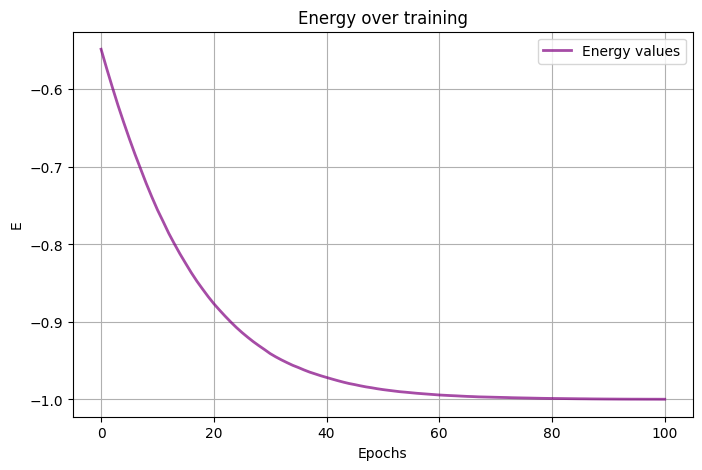

In [53]:
# plotting function here
plot_expectations(expectations)

## 5. PSR in `Qibo`

In `Qibo` this PSR is implemented and can be used by calling

In [10]:
from qibo.derivative import parameter_shift

parameter_shift(
    circuit=c,
    hamiltonian=h,
    parameter_index=0
)

-0.004611207698658276

#### References

[1] [_Quantum Circuit Learning_, 2018](https://arxiv.org/abs/1803.00745)

[2] [_Evaluating analytic gradients on quantum hardware_, 2018](https://arxiv.org/abs/1811.11184)